---
### 시계열 분석

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler

In [25]:
# 시계열 분석
# 2개의 피쳐(종가, 거래량)로 타깃(종가) 예측
df = pd.read_csv('../csv/AAPL.csv')

In [26]:
# 특정 컬럼을 선택
df =  df[['Date', 'Adj Close', 'Volume']]
df.dropna(axis=0, inplace=True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9713 entries, 0 to 9714
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9713 non-null   object 
 1   Adj Close  9713 non-null   float64
 2   Volume     9713 non-null   float64
dtypes: float64(2), object(1)
memory usage: 303.5+ KB


In [32]:
# 피쳐 데이터(독립)
    # int나 object형이라면 float으로 변환 
X_all = df[['Adj Close', 'Volume']].astype('float').values
# 타깃 데이터(종속)
y_all = df[['Adj Close']].astype('float').values

In [29]:
# 데이터의 분할
# 4개의 데이터 생성 -> 8:2로 분할
#  => train_test_split() 함수와 같은 부분
split_idx = int( len(df) * 0.8 )

X_train, X_test = X_all[ :split_idx], X_all[split_idx: ]
y_train, y_test = y_all[ :split_idx], y_all[split_idx: ]

In [ ]:
# 스케일링 (예측 종가, 실제 종가 데이터의 원본으로 마지막에 편하게 역변환하기 위해)
# 학습(fit)되는 기준이 다르기 때문에, inverse_transform()을 통해 예측값과 실제값을 원본 스케일로 정확하게 복원하기 위해 분리 필수
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_sc = x_scaler.fit_transform(X_train)
X_test_sc = x_scaler.transform(X_test)

y_train_sc = y_scaler.fit_transform(y_train)
y_test_sc = y_scaler.transform(y_test)

In [ ]:
# DataLoader 에서 구간 데이터를 나눠주기 위한 DataSet 구성
class WindowDataset(Dataset):
    def __init__(self, _x, _y, _window):
        # _x: 독립
        # _y: 종속
        # _window: 구간
        self.x = _x
        self.y = _y
        self.window = _window
        self.n = len(_x) - _window

    # Dataloader에서 사용되는 특수 메서드 정의: __len__(), __getitem__()
    def __len__(self):
        return max(self.n, 1)
    def __getitem__(self, index):
        # 입력 데이터 (문제)
        x_window = self.x[ index : index+self.window ]
        # 타깃 데이터 (정답)
        y_next = self.y[ index+self.window ]
        # tensor 데이터로 변환 (self.x, self.y를 array 형태로 받는다는 가정)
        # tensor() - tensor형으로 데이터를 변환 (깊은 복사: 데이터를 각각의 다른 위치에 저장)
        # from_numpy() - tensor형으로 데이터를 변환 (얕은 복사: 데이터의 위치는 같고 라벨을 추가)
        x_tensor = torch.from_numpy(x_window)
        y_tensor = torch.from_numpy(y_next)
        return x_tensor, y_tensor

#### cf. 깊은 복사와 얕은 복사
**깊은 복사** (Deep Copy)
</br>: 원본 객체와 복사본이 완전히 독립적이 되도록 만드는 방법
- *copy.deepcopy()*
- 복사본은 원본 객체의 하위 요소들을 복사한 새로운 사본을 가진다.
- 복사본을 수정해도 원본 객체에는 아무런 영향을 미치지 않는다.

**얕은 복사**(Shallow Copy)
</br>: 최상위 객체만 복사하고 하위 객체는 원본과 메모리를 공유하는 방법
- *copy.copy()* 또는 슬라이싱
- 얕게 복사된 객체의 하위 요소를 수정하면 원본 객체도 함께 변경되는 문제가 발생
- 중첩된 객체는 독립적이지 않다

In [12]:
# RNN class 정의
class RNNReg(nn.Module):
    # 해당 class에서 정의되는 함수는 생성자함수, forward() 함수

    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers= 1,
            nonlinearity= 'tanh',
            dropout= 0.0,
            bidirectional= False,
            batch_first= True
        ):
        # 부모 클래스의 생성자 함수 호출
        super().__init__()
        self.rnn = nn.RNN(
            input_size= input_size,
            hidden_size= hidden_size,
            num_layers= num_layers,
            nonlinearity= nonlinearity,
            dropout= dropout,
            bidirectional= bidirectional,
            batch_first= batch_first
        )
        # self.head = nn.linear(hidden_size, 1) # 1차원 스칼라 회귀
        # bidirectional의 값이 False인 경우에는 hidden_size를 사용
        # 만약 True라면 hidden_size * 2 (양방향이므로)
        out_features = hidden_size * ( 2 if bidirectional else 1 )
        # 선형 학습 모델 -> 비선형 학습 모델
        # self.head = nn.Linear(out_features, 1)    # 선형
        self.head = nn.Sequential(
            nn.Linear(out_features, out_features*2),
            nn.ReLU(),
            nn.Linear(out_features*2, 1)
        )
    def forward(self, x):
        # out -> 모든 시점에서의 은닉층의 값(결과)
        # h_n -> 마지막 시점에서의 은닉층의 값(결과) -> 시계열 분석은 마지막 시점(층이 존재하면 층별 마지막값)을 사용
        out, h_n = self.rnn(x)
        # 층이 여러 개일 수도 있으니, 가장 마지막 은닉층의 값을 사용 (마지막 층의 값)
        last_hidden = h_n[-1]
        res = self.head(last_hidden)
        return res

In [33]:
# 구간별 데이터셋 구성
train_ds = WindowDataset(X_train_sc, y_train_sc, 60)
test_ds = WindowDataset(X_test_sc, y_test_sc, 60)

train_dl = DataLoader(train_ds, shuffle=True, drop_last=True, batch_size=64)
test_dl = DataLoader(test_ds, shuffle=False, drop_last=False, batch_size=256)

- input_size = 2로 변경
- inverse_transform 하기 위해 y에도 스케일러를 따로 썼기 때문에 y_scaler도 사용해줘야 함

In [34]:
# 모델 생성
aapl_model = RNNReg( input_size= 2, hidden_size= 128)

In [35]:
aapl_model.eval()

preds, trues = [], []

with torch.no_grad():
    for x, y in test_dl:
        x = x.float()
        y = y.float()
        yhat = aapl_model(x)
        preds.append(yhat.cpu())
        trues.append(y.cpu())

# preds, trues를 numpy 형태로 변환
preds = torch.cat(preds, dim=0).squeeze(-1).numpy()
trues = torch.cat(trues, dim=0).squeeze(-1).numpy()

In [36]:
# 손실함수
criterion = nn.MSELoss()
# 옵티마이저
optimizer = optim.Adam(aapl_model.parameters(), lr = 0.0001)

In [37]:
@torch.no_grad()                    # 이렇게 하거나
def evaluate_mse(dataloader):
    aapl_model.eval()
    total_loss, total_n = 0.0, 0
    # with torch.no_grad():         # 이렇게 하거나
    for x, y in dataloader:
        x = x.float()
        y = y.float()
        yhat = aapl_model(x)
        loss = criterion(yhat, y)
        total_loss += loss.item() * y.size(0)
        total_n += y.size(0)
    return total_loss / max(total_n, 1)

train_history, val_history = [], []
for epoch in range(20):
    aapl_model.train()
    running, n_seen = 0.0, 0
    for x, y in train_dl:
        x = x.float()
        y = y.float()
        optimizer.zero_grad()
        yhat = aapl_model(x)
        loss = criterion(yhat, y)
        loss.backward()
        # 기울기 폭주 방지 - nan값이 나올 수 있는 확률을 배제
        nn.utils.clip_grad_norm_(aapl_model.parameters(), 1.0)

        optimizer.step()

        running += loss.item() * y.size(0)
        n_seen += y.size(0)
    
    train_mse = running / max(n_seen, 1)
    val_mse = evaluate_mse(test_dl)
    train_history.append(train_mse)
    val_history.append(val_mse)
    print(f"epoch: {epoch+1}, train_mse: {train_mse :.4f}, val_mse: {val_mse :.4f}")

epoch: 1, train_mse: 0.3908, val_mse: 67.6022
epoch: 2, train_mse: 0.0104, val_mse: 53.2489
epoch: 3, train_mse: 0.0028, val_mse: 49.2214
epoch: 4, train_mse: 0.0016, val_mse: 47.4167
epoch: 5, train_mse: 0.0013, val_mse: 46.3627
epoch: 6, train_mse: 0.0011, val_mse: 45.5156
epoch: 7, train_mse: 0.0011, val_mse: 44.9028
epoch: 8, train_mse: 0.0010, val_mse: 43.9925
epoch: 9, train_mse: 0.0011, val_mse: 43.5944
epoch: 10, train_mse: 0.0010, val_mse: 42.9550
epoch: 11, train_mse: 0.0010, val_mse: 42.1512
epoch: 12, train_mse: 0.0010, val_mse: 41.7101
epoch: 13, train_mse: 0.0010, val_mse: 41.2513
epoch: 14, train_mse: 0.0010, val_mse: 40.4979
epoch: 15, train_mse: 0.0010, val_mse: 40.1715
epoch: 16, train_mse: 0.0009, val_mse: 39.4744
epoch: 17, train_mse: 0.0009, val_mse: 38.8795
epoch: 18, train_mse: 0.0009, val_mse: 38.6882
epoch: 19, train_mse: 0.0009, val_mse: 38.3408
epoch: 20, train_mse: 0.0009, val_mse: 37.6620


In [41]:
# 검증 셋 예측값과 실젯값을 그래프로 시각화
aapl_model.eval()

preds, trues = [], []

with torch.no_grad():
    for x, y in test_dl:
        x = x.float()
        y = y.float()
        yhat = aapl_model(x)
        preds.append(yhat.cpu())
        trues.append(y.cpu())

# preds, trues를 numpy 형태로 변환
preds = torch.cat(preds, dim=0).squeeze(-1).numpy()
trues = torch.cat(trues, dim=0).squeeze(-1).numpy()

In [42]:
# 스케일링 데이터를 다시 원본의 데이터셋으로 변경
# inverse_transform(): 스케일링 데이터를 원본으로 변경
preds_origin = y_scaler.inverse_transform(preds.reshape(-1, 1)).squeeze()
trues_origin = y_scaler.inverse_transform(trues.reshape(-1, 1)).squeeze()

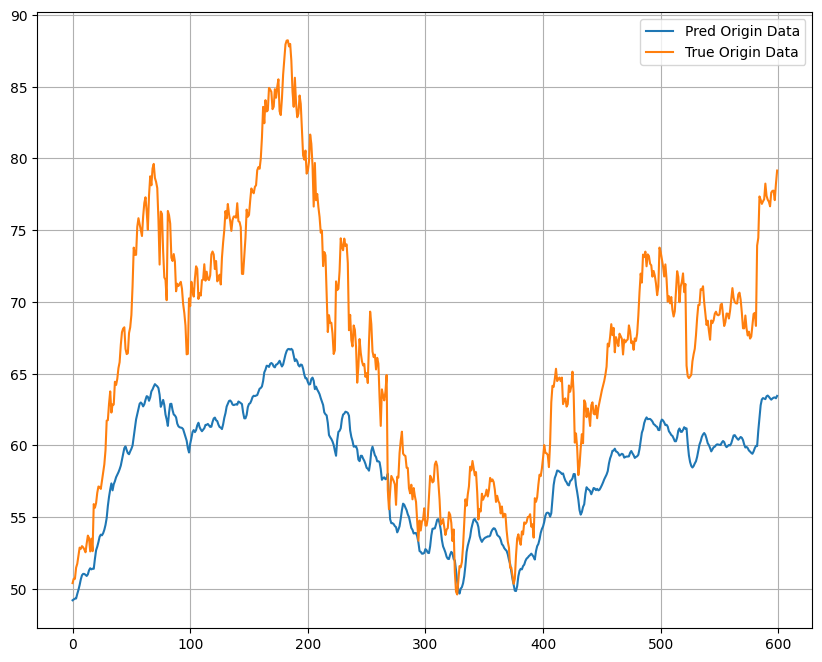

In [46]:
plt.figure(figsize=(10, 8))
plt.plot(preds_origin[:600], label= 'Pred Origin Data')
plt.plot(trues_origin[:600], label= 'True Origin Data')
plt.legend()
plt.grid(True)
plt.show()